# Profundizando en Tensorflow

Aqui vamos a estudiar las herramientas que se usaran para construir modelos de deep learning, esto es [Tensorflow](https://www.tensorflow.org/).

En primer lugar, instalar Tensorflow con pip:
* `pip install tensorflow` , solo TF en cpu tanto en Linux comom en Mac OS
* Si quieres soporte para GPU mira esta pagina: [instalacion TF](https://www.tensorflow.org/install/)

# Visualizacion

Ejecutando este notebook localmente, el acceso a TensorBoard seria en http://127.0.0.1:7007/

In [1]:
! killall tensorboard
import os
os.system('tensorboard --logdir=/tmp/tboard --port=7007 &');

No matching processes belonging to you were found


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()

Using TensorFlow backend.


# Empezando
Para empezar vamos a implementar una funcion que calcule la suma de los cuadrados de los numeros de 0 a N-1.

In [3]:
import numpy as np
def suma_cuad(N):
    return np.sum(np.arange(N)**2)

In [4]:
%%time
suma_cuad(10**5)

CPU times: user 718 µs, sys: 672 µs, total: 1.39 ms
Wall time: 814 µs


333328333350000

# Tensoflow 

Hacemos exactamente lo mismo con Tensorflow

In [5]:
# Un parametro entero
N = tf.placeholder('int64', name='entrada_a_la_funcion')

# Produce el mimso resultado
res = tf.reduce_sum(tf.range(N)**2)

In [6]:
res

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [7]:
%%time
res.eval({N: 10**5})

CPU times: user 3.12 ms, sys: 1.3 ms, total: 4.42 ms
Wall time: 2.61 ms


333328333350000

In [8]:
escritor = tf.summary.FileWriter('/tmp/tboard', graph=s.graph)

# ¿Como funciona?
1. Se definen unos marcadores (placeholders) donde se envian las entradas (inputs)
2. Se hace un grafo simbolico (symbolic graph): una receta para transformaciones matematicas de esos marcadores 
3. Se calculan las salidas del grafo con valores para cada marcador
  * `salida.eval({marcador:valor})`
  * `s.run(salida, {marcador:valor})`

Asi que existen dos entidades principales: el marcador (placeholder) y la transformacion matematica
* Ambos pueden ser numeros, vectores, matrices, tensores, etc...
* Ambos pueden ser int32/64, floats, booleanos (uint8)...
* Se pueden definir nuevas transformaciones como operaciones arbitrarias en los marcadores y otras transformaciones
 * `tf.reduce_sum(tf.arange(N)**2)` son 3 transformaciones secuenciales del marcador `N`
 * Hay una version simbolica en Tensorflow para cada funcion de numpy 
   * `a+b, a/b, a**b, ...` se comporta igual que en numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * Si no encuentras la funcion que necesitas, puedes mirar la [documentacion](https://www.tensorflow.org/api_docs/python).
   
`tf.contrib` tiene muchas caracteristicas de alto nivel, echale un ojo.

In [9]:
with tf.name_scope('Ejemplo_marcadores'):
    # El marcador por defecto (placeholder) puede ser arbitrariamente float32
    # escalar, vector, matrix, etc...
    entrada_arbitraria = tf.placeholder('float32')

    # Vector de entrada de longitud arbitraria
    vector_entrada = tf.placeholder('float32', shape=(None,))

    # Vector de entrada que tienec 10 elementos de tipo entero
    vector_fijo = tf.placeholder('int32', shape=(10,))

    # Matriz con numero de filas arbitrario y 15 columnas
    # (e.g. una muestra de tu tabla de datos)
    matriz_entrada = tf.placeholder('float32', shape=(None, 15))
    
    # Generalmente se usa None cuando no se necesita especificar la dimension
    entrada1 = tf.placeholder('float64', shape=(None, 100, None))
    entrada2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # Multiplicacion elemento a elemento
    vector_doble = vector_entrada*2

    # Coseno
    coseno = tf.cos(vector_entrada)

    # Diferencia entre el vector al cuadrado y el propio vector mas uno 
    cuadrado_vector = vector_entrada**2 - vector_entrada + 1

In [10]:
mi_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
mi_vector2 = tf.placeholder('float32', shape=(None,))
mi_transformacion = mi_vector * mi_vector2 / (tf.sin(mi_vector) + 1)

In [11]:
print(mi_transformacion)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [12]:
dummy = np.arange(5).astype('float32')
print(dummy)
mi_transformacion.eval({mi_vector:dummy, mi_vector2:dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [13]:
escritor.add_graph(mi_transformacion.graph)
escritor.flush()

TensorBoard permite escribir escalares, imagenes, audio, histogramas. Puedes leer mas sobre tensorboard [aqui](https://www.tensorflow.org/get_started/graph_viz).

# Resumen
* Tensorflow esta basado en la computacion de grafos
* Los grafos constan de marcadores (placeholders) y transformaciones

# Error cuadratico medio

La tarea es implementar el error cuadratico medio en Tensorflow.

In [14]:
y = np.arange(5)
y_pred = np.arange(5)[::-1]

In [15]:
(y - y_pred) ** 2

array([16,  4,  0,  4, 16])

In [16]:
with tf.name_scope('MSE'):
    y_true = tf.placeholder('float32', shape=(None,), name='y_true')
    y_predicho = tf.placeholder('float32', shape=(None,), name='y_predicho')
    mse = tf.reduce_mean((y_true - y_predicho) ** 2)
def c_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicho: vector2})

In [17]:
escritor.add_graph(mse.graph)
escritor.flush()

In [19]:
# Testeo local de la implementacion del MSE
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for e in elems:
        for e_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(e, e_2))
            mi_mse = c_mse(e, e_2)
            if not np.allclose(true_mse, mi_mse):
                print('mse({},{})'.format(e, e_2))
                print('deberia ser: {}, pero la funcion devuelve {}'.format(true_mse, mi_mse))
                raise ValueError('Resultado incorrecto')

# Variables

Las entradas y las transformaciones no tienen valores fuera de la funcion. Esto no es demasiado comodo si quieres que el modelo tenga parametros (e.g. pesos de la red) que cambien en el tiempo.

Tensorflow soluciona esto con objetos `tf.Variable`.
* Se puede asignar a la variable un valor en cualquier momento en el grafo
* A diferencia de los marcadores, no hay necesidad de pasar explicitamente valores a las variables cuando se ejecuta `s.run(...)`
* Se pueden usar variables de la misma manera que se usan transformaciones 
 

In [20]:
# Creando una variable compartida
comp_vector_1 = tf.Variable(initial_value=np.ones(5), name='ejemplo_variable')

In [21]:
# Inicializar variables con valores iniciales
s.run(tf.global_variables_initializer())

# Evaluando la variable compartida 
print('Valor inicial', s.run(comp_vector_1))


Initial value [1. 1. 1. 1. 1.]


In [22]:
# Configurando nuevo valor
s.run(comp_vector_1.assign(np.arange(5)))

# Obteniendo nuevo valor
print('Nuevo valor', s.run(comp_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - por que importan los grafos
* Tensorflow can computar las derivadas y los gradientes automaticamente usando la computacion de grafos
* Puede manejar derivadas de matrices
* Los gradientes se calculan como un producto de derivadas a traves de la regla de la cadena:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Por lo tanto se puede derivar cualquier grafo si se sabe derivar de manera elemental.

In [28]:
escalar = tf.placeholder('float32')

escalar_cuadrado = escalar**2

# Derivada del cuadrado del escalar por el propio escalar
derivada = tf.gradients(escalar_cuadrado, [escalar, ])

In [29]:
derivada

[<tf.Tensor 'gradients_3/pow_11_grad/Reshape:0' shape=<unknown> dtype=float32>]

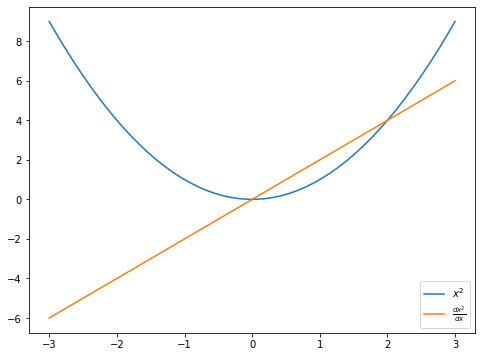

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_cuad, x_cuad_der = s.run([escalar_cuadrado, derivada[0]], {escalar:x})

plt.figure(figsize=(8,6))
plt.plot(x, x_cuad, label='$x^2$')
plt.plot(x, x_cuad_der, label=r'$\frac{dx^2}{dx}$')
plt.legend();

# Por que mola

In [26]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

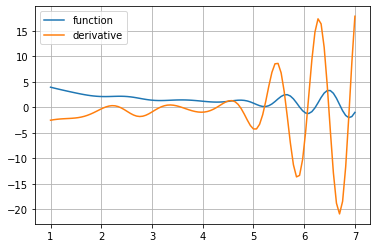

In [27]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic grads from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [ ]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')
loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 
#loss = tf.reduce_mean((y_guess - y_true)**2) 
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(
    loss, var_list=y_guess)

In [ ]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

guesses = [s.run(y_guess)]

def animate(i):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    line.set_data(*zip(*guesses))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
try:
    display_html(HTML(anim.to_html5_video()))
# In case the build-in renderers are unaviable, fall back to
# a custom one, that doesn't require external libraries
except (RuntimeError, KeyError):
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

# Logistic regression
Your assignment is to implement the logistic regression

Plan:
* Use a shared variable for weights
* Use a matrix placeholder for `X`
 
We shall train on a two-class MNIST dataset
* please note that target `y` are `{0,1}` and not `{-1,1}` as in some formulae

In [ ]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

In [ ]:
print('X:\n',X[:3,:10])
print('y:\n',y[:10])
plt.imshow(X[7].reshape([8,8]));

It's your turn now!
Just a small reminder of the relevant math:

$$
P(y=1|X) = \sigma(X \cdot W + b)
$$
$$
\text{loss} = -\log\left(P\left(y_\text{predicted} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicted} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ is available via `tf.nn.sigmoid` and matrix multiplication via `tf.matmul`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

__Your code goes here.__ For the training and testing scaffolding to work, please stick to the names in comments.

In [ ]:
# Model parameters - weights and bias
# weights = tf.Variable(...) shape should be (X.shape[1], 1)
# b = tf.Variable(...)

weights = tf.Variable(np.zeros((X.shape[1], 1), dtype='float32'))
b = tf.Variable(np.zeros(None), dtype='float32')

In [ ]:
# Placeholders for the input data
# input_X = tf.placeholder(...)
# input_y = tf.placeholder(...)

input_X = tf.placeholder("float32", shape=(None, X.shape[1]), name="input_X")
input_y = tf.placeholder("float32", shape=(None,), name="input_y")

In [ ]:
# The model code

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
# This is 1D, if you have extra dimensions, you can  get rid of them with tf.squeeze .
# Don't forget the sigmoid.
# predicted_y = <predicted probabilities for input_X>

predicted_y = tf.squeeze(tf.sigmoid(input_X @ weights + b))

# Loss. Should be a scalar number - average loss over all the objects
# tf.reduce_mean is your friend here
# loss = <logistic loss (scalar, mean over sample)>
loss = tf.reduce_mean(-tf.log(predicted_y) * input_y - tf.log(1 - predicted_y) * (1 - input_y))

# See above for an example. tf.train.*Optimizer
# optimizer = <optimizer that minimizes loss>
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(loss, var_list=[weights, b])

A test to help with the debugging

In [ ]:
validation_weights = 1e-3 * np.fromiter(map(lambda x:
        s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 0.1, 2]}),
                                   0.15 * np.arange(1, X.shape[1] + 1)),
                                   count=X.shape[1], dtype=np.float32)[:, np.newaxis]

# Compute predictions for given weights and bias
prediction_validation = s.run(
    predicted_y, {
    input_X: X,
    weights: validation_weights,
    b: 1e-1})

#prediction_validation = prediction_validation.flatten()

# Load the reference values for the predictions
validation_true_values = np.loadtxt("predicciones_de_validacion.txt")

assert prediction_validation.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in input_X"
assert np.allclose(validation_true_values, prediction_validation)
loss_validation = s.run(
        loss, {
            input_X: X[:100],
            input_y: y[-100:],
            weights: validation_weights+1.21e-3,
            b: -1e-1})
assert np.allclose(loss_validation, 0.728689)

In [ ]:
from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())
for i in range(5):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train, s.run(predicted_y, {input_X:X_train})))
    print("test auc:", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

In [ ]:
# era submision aqui

In [ ]:
test_weights = 1e-3 * np.fromiter(map(lambda x:
    s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]}),
                               0.1 * np.arange(1, X.shape[1] + 1)),
                               count=X.shape[1], dtype=np.float32)[:, np.newaxis]

First, test prediction and loss computation. This part doesn't require a fitted model.

In [ ]:
prediction_test = s.run(
    predicted_y, {
    input_X: X,
    weights: test_weights,
    b: 1e-1})

In [ ]:
assert prediction_test.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in X_test"

In [ ]:
loss_test = s.run(
    loss, {
        input_X: X[:100],
        input_y: y[-100:],
        weights: test_weights+1.21e-3,
        b: -1e-1})
# Yes, the X/y indices mistmach is intentional